In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 10
batch_size = 5
learning_rate = 0.001

In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [25]:
data_dir = 'Rice_Image_Dataset'
x = 'train'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])}
print(image_datasets)

train_size = int(0.8 * len(image_datasets[x]))
test_size = len(image_datasets[x]) - train_size
print(train_size,test_size)

train_dataset, test_dataset = torch.utils.data.random_split(image_datasets[x], [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

{'train': Dataset ImageFolder
    Number of datapoints: 75000
    Root location: Rice_Image_Dataset/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )}
60000 15000


In [28]:
print(len(train_dataset))
print(len(test_dataset))

60000
15000


('Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag')


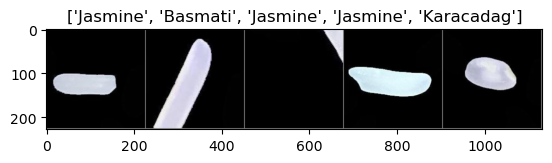

In [34]:
#class_names = image_datasets['train'].classes
class_names = ('Arborio', 'Basmati', 'Ipsala','Jasmine','Karacadag')
print(class_names)
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

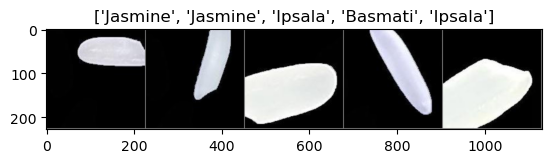

In [36]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(test_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [37]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 3 color channels input, 6 output size and 5 is kernel size
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)
        # input size must be equaled with the output size of conv1
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # output size * the size of image
        self.fc1 = nn.Linear(64*28*28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    '''
    nn.Conv2d function:
    example: 5*5 input 3*3 filter padding=0 stride=1
    (W-F + 2*P)/S + 1
    (5-3 + 2*0)/1 +1 = 3 
    ->3*3

    pooling function:
    2*2 means 3*3/2 -> 1.5*1.5
    '''

    def forward(self, x):
        # -> n(batch size), 3(color channels), 32, 32(32*32 images)
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        #print(x.shape)  # 查看每一步的输出形状
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        #print(x.shape)  # 查看每一步的输出形状
        x = self.pool(F.relu(self.conv3(x)))  # -> n, 16, 5, 5
        #print(x.shape)  # 查看每一步的输出形状
        # This reshapes the 4D tensor (n, 16, 5, 5) 
        # into a 2D tensor with shape (n, 400)
        # nn.Linear need a 2D tensor like (batch size, 16 * 5 * 5)
        x = x.view(-1, 64*28*28)            # -> n, 400
        #print(x.shape)  # 查看每一步的输出形状
        x = F.relu(self.fc1(x))               # -> n, 120
        #print(x.shape)  # 查看每一步的输出形状
        x = F.relu(self.fc2(x))               # -> n, 84
        #print(x.shape)  # 查看每一步的输出形状
        x = self.fc3(x)                       # -> n, 10
        #print(x.shape)  # 查看每一步的输出形状
        return x

In [38]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch [1/10], Step [2000/12000], Loss: 0.9452
Epoch [1/10], Step [4000/12000], Loss: 0.6135
Epoch [1/10], Step [6000/12000], Loss: 0.9875
Epoch [1/10], Step [8000/12000], Loss: 0.5902
Epoch [1/10], Step [10000/12000], Loss: 0.6224
Epoch [1/10], Step [12000/12000], Loss: 0.1397
Epoch [2/10], Step [2000/12000], Loss: 0.2778
Epoch [2/10], Step [4000/12000], Loss: 0.3696
Epoch [2/10], Step [6000/12000], Loss: 1.2570
Epoch [2/10], Step [8000/12000], Loss: 0.1983
Epoch [2/10], Step [10000/12000], Loss: 0.0518
Epoch [2/10], Step [12000/12000], Loss: 0.4095
Epoch [3/10], Step [2000/12000], Loss: 0.1551
Epoch [3/10], Step [4000/12000], Loss: 0.3012
Epoch [3/10], Step [6000/12000], Loss: 0.1612
Epoch [3/10], Step [8000/12000], Loss: 0.8637
Epoch [3/10], Step [10000/12000], Loss: 0.0221
Epoch [3/10], Step [12000/12000], Loss: 0.1084
Epoch [4/10], Step [2000/12000], Loss: 0.3004
Epoch [4/10], Step [4000/12000], Loss: 0.1341
Epoch [4/10], Step [6000/12000], Loss: 0.1831
Epoch [4/10], Step [8000/120

In [39]:

print('Finished Training')
PATH = './cnn2.pth'
torch.save(model.state_dict(), PATH)


Finished Training


In [40]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {class_names[i]}: {acc} %')

Accuracy of the network: 94.9 %
Accuracy of Arborio: 97.46401644962303 %
Accuracy of Basmati: 95.4515491100857 %
Accuracy of Ipsala: 99.35854152599595 %
Accuracy of Jasmine: 89.28571428571429 %
Accuracy of Karacadag: 93.17732366512854 %
